# Fitting a bivariate log-Gaussian Cox process to vessel distributions

In [1]:
from itertools import product
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from plotnine import *

## data

In [2]:
data = pd.read_csv('data/talara.csv')

# split into AIS and Satellite
foo = data.groupby('type')
foo1 = foo.get_group('ais')
foo2 = foo.get_group('satellite')

xy1 = foo1[['x_m', 'y_m']].values
xy2 = foo2[['x_m', 'y_m']].values

# region range in meter
height = 10000
width = 10000

# resolution for binning
resolution = 1000

# number of cells 
n_cells_x = int(width/resolution)
n_cells_y = int(height/resolution)

# grid location
grid_x = np.linspace(0, width, n_cells_x + 1)
grid_y = np.linspace(0, height, n_cells_y + 1)

# centroid of each cell
centroid = np.asarray(list(product(grid_x[:-1] + 0.5*resolution, grid_y[:-1] + 0.5*resolution)))

# count the number of vessels per cell
n_vessels1, _, _ = np.histogram2d(xy1[:, 0], xy1[:, 1], [grid_x, grid_y])
n_vessels1 = n_vessels1.ravel().astype(int)

n_vessels2, _, _ = np.histogram2d(xy2[:, 0], xy2[:, 1], [grid_x, grid_y])
n_vessels2 = n_vessels2.ravel().astype(int)

n_vessels = np.stack([n_vessels1, n_vessels2])

## Model

In [3]:
# gaussian processes with mean 0 standard deviation 1
with pm.Model() as mlgcp:
    rho = pm.Uniform("rho", lower=100, upper=5000)
    cov = 1**2 * pm.gp.cov.ExpQuad(2, ls=rho) + pm.gp.cov.WhiteNoise(1e-6)

    gp1 = pm.gp.Latent(cov_func=cov)
    gp2 = pm.gp.Latent(cov_func=cov)

    V1 = gp1.prior("V1", X=centroid)
    V2 = gp2.prior("V2", X=centroid)

# bivariate lgcp
with mlgcp:
    # dependence
    a11 = pm.Exponential('a11', lam=1)
    a22 = pm.Exponential('a22', lam=1)
    a21 = pm.Normal('a21', mu=0, sigma=10)

    # intercept
    mu1 = pm.Normal('mu1', mu=0, sigma=10)
    mu2 = pm.Normal('mu2', mu=0, sigma=10)

    log_intensity1 = mu1 + a11 * V1
    log_intensity2 = mu2 + a21 * V1 + a22 * V2

    intensity1 = pm.Deterministic('intensity1', pm.math.exp(log_intensity1))
    intensity2 = pm.Deterministic('intensity2', pm.math.exp(log_intensity2))

    intensity = pm.math.stack([intensity1, intensity2])

    y = pm.Poisson("y", mu=intensity, observed=n_vessels)

## Run

In [4]:
with mlgcp:
    trace = pm.sample(draws=1000, tune=1000, target_accept=0.95, chains=2, return_inferencedata=True)

# save
trace.to_netcdf('data/inference_talara.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [rho, V1_rotated_, V2_rotated_, a11, a22, a21, mu1, mu2]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1303 seconds.


'data/inference_talara.nc'

## Check convergence

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,884.630,102.125,708.808,1085.618,4.590,3.285,510.0,618.0,1.0
mu1,-1.307,0.515,-2.242,-0.293,0.013,0.010,1496.0,1459.0,1.0
mu2,-1.108,0.421,-1.884,-0.317,0.010,0.008,1710.0,1564.0,1.0
a11,2.170,0.304,1.615,2.733,0.011,0.008,812.0,1241.0,1.0
a22,1.128,0.248,0.687,1.622,0.008,0.005,1020.0,1457.0,1.0
a21,1.164,0.283,0.678,1.723,0.008,0.006,1312.0,1107.0,1.0


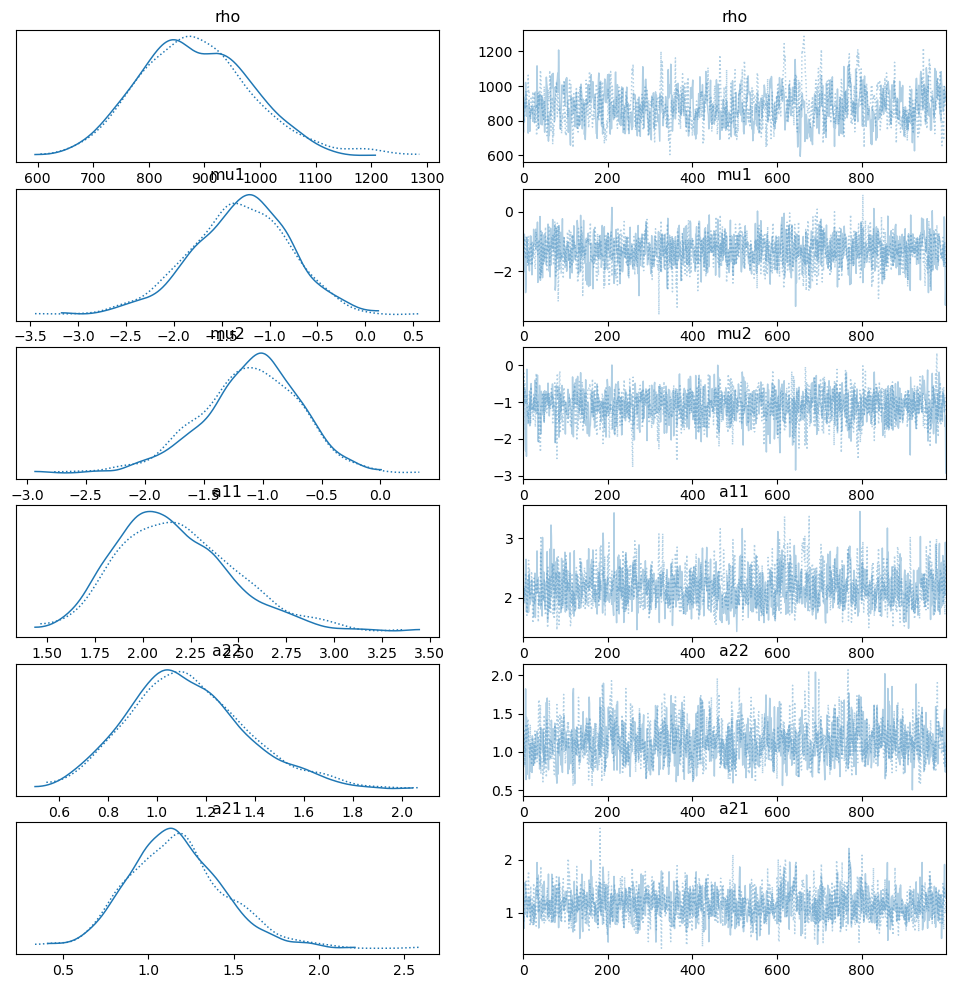

In [6]:
az.plot_trace(trace, var_names=['rho', 'mu1', 'mu2', 'a11', 'a22', 'a21'])
az.summary(trace, var_names=['rho', 'mu1', 'mu2', 'a11', 'a22', 'a21'])

## Check posterior predictive

Sampling: [y]


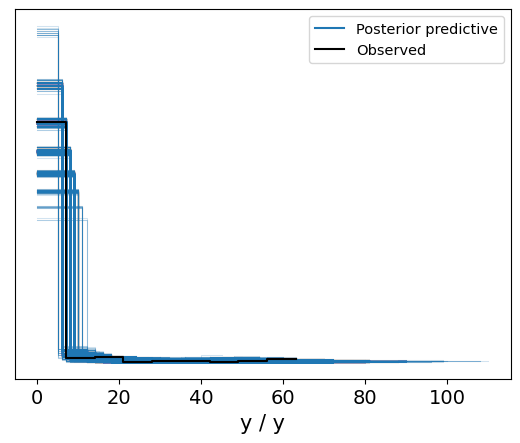

In [8]:
with mlgcp:
    ppc = pm.sample_posterior_predictive(trace)

az.plot_ppc(ppc, mean=False);

## Plot model fit

In [9]:
trace = az.from_netcdf('data/inference_talara.nc')

In [10]:
resolution = 200

# number of cells 
n_cells_x = int(width/resolution)
n_cells_y = int(height/resolution)

# grid location
grid_x = np.linspace(0, width, n_cells_x + 1)
grid_y = np.linspace(0, height, n_cells_y + 1)

# centroid of each cell
centroid_new = np.asarray(list(product(grid_x[:-1] + 0.5*resolution, grid_y[:-1] + 0.5*resolution)))

In [11]:
with mlgcp:
    V1_new = gp1.conditional('V1_new', Xnew=centroid_new)
    V2_new = gp2.conditional('V2_new', Xnew=centroid_new)

    log_intensity1_new = mu1 + a11 * V1_new
    log_intensity2_new = mu2 + a21 * V1_new + a22 * V2_new

    intensity1_new = pm.Deterministic('intensity1_new', pm.math.exp(log_intensity1_new))
    intensity2_new = pm.Deterministic('intensity2_new', pm.math.exp(log_intensity2_new))

    trace_new = pm.sample_posterior_predictive(trace, var_names=['intensity1_new', 'intensity2_new'])


In [12]:
foo = pd.DataFrame()
foo['x'] = centroid_new[:,0]
foo['y'] = centroid_new[:,1]
foo['fitted1'] = trace_new['intensity1_new'].mean(axis=0)
foo['fitted2'] = trace_new['intensity2_new'].mean(axis=0)

p1 = ggplot(foo, aes('x', 'y', fill='fitted1')) + geom_tile() + coord_fixed()
p2 = ggplot(foo, aes('x', 'y', fill='fitted2')) + geom_tile() + coord_fixed()

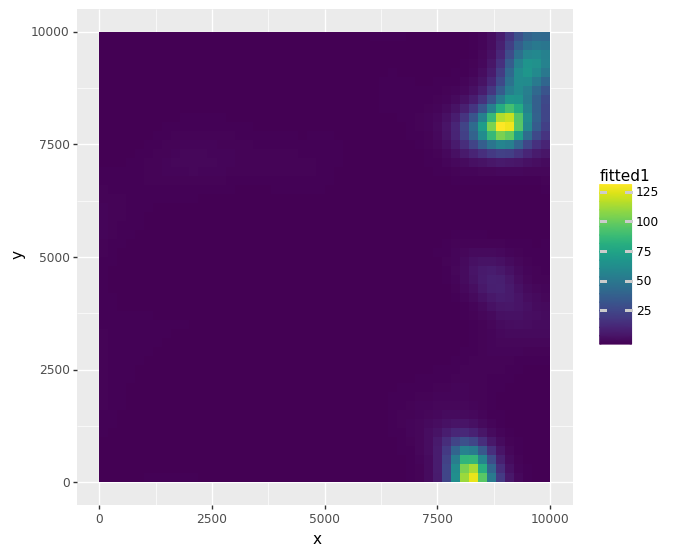

<ggplot: (372218569)>

In [13]:
p1

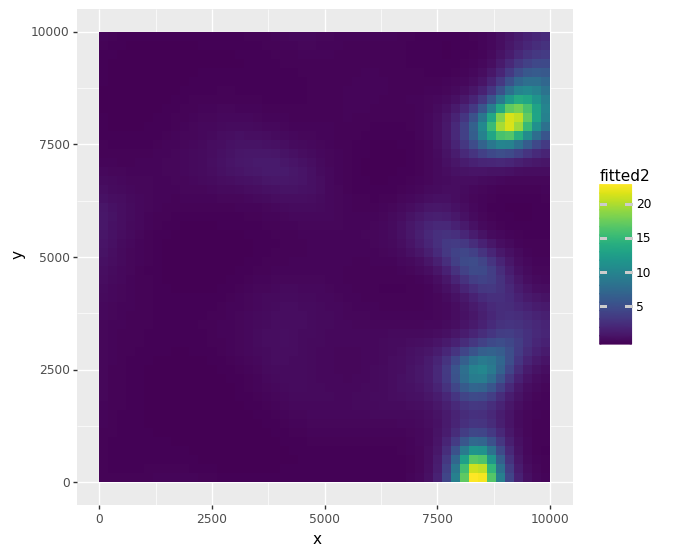

<ggplot: (372820661)>

In [16]:
p2

In [18]:
foo.to_csv('data/pp_talara.csv', index=False)